<a href="https://colab.research.google.com/github/gosaitos/Computer_vision/blob/main/Image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread("apple.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [ ]:
# 1. Graph Cut (GrabCut Algorithm)
mask = np.zeros(image.shape[:2], np.uint8)
bgd_model = np.zeros((1, 65), np.float64)
fgd_model = np.zeros((1, 65), np.float64)
rect = (25,40,300,300)
cv2.grabCut(image, mask, rect, bgd_model, fgd_model, 5, cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
graph_cut_result = image * mask2[:, :, np.newaxis]

In [ ]:
# 2. Mean Shift Segmentation with Edge Highlight
mean_shift = cv2.pyrMeanShiftFiltering(image, 50, 50)

In [ ]:
# 3. K-Means Clustering
Z = image.reshape((-1, 3))
Z = np.float32(Z)
k = 5
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
_, labels, centers = cv2.kmeans(Z, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
kmeans_result = centers[labels.flatten()].reshape(image.shape)
kmeans_result = np.uint8(kmeans_result)

In [ ]:
# 4. Otsu's Thresholding
thresh_val, otsu_thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [ ]:
# 5. Region Growing (Fixed Version)
def region_growing(image, seed, threshold=5):
    height, width = image.shape
    segmented = np.zeros_like(image, np.uint8)
    seed_value = image[seed[1], seed[0]]
    stack = [seed]
    visited = set()

    while stack:
        x, y = stack.pop()
        if (x, y) in visited:
            continue
        visited.add((x, y))
        if abs(int(image[y, x]) - int(seed_value)) < threshold:
            segmented[y, x] = 255
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height:
                    stack.append((nx, ny))
    return segmented

seed_point = (200,100)
region_growing_result = region_growing(gray_image, seed_point, threshold=63)

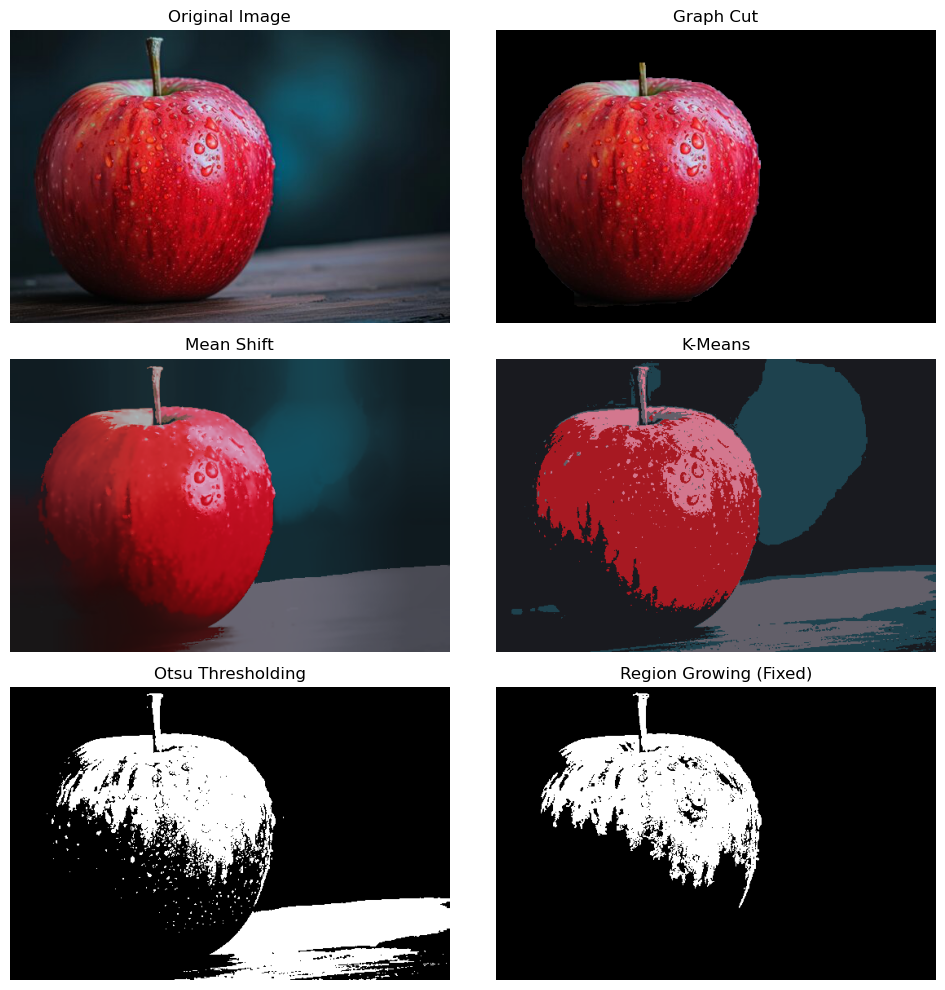

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 10))
axes[0, 0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original Image")
axes[0, 1].imshow(cv2.cvtColor(graph_cut_result, cv2.COLOR_BGR2RGB))
axes[0, 1].set_title("Graph Cut")
axes[1, 0].imshow(cv2.cvtColor(mean_shift, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Mean Shift")
axes[1, 1].imshow(cv2.cvtColor(kmeans_result, cv2.COLOR_BGR2RGB))
axes[1, 1].set_title("K-Means")
axes[2, 0].imshow(otsu_thresh, cmap='gray')
axes[2, 0].set_title("Otsu Thresholding")
axes[2, 1].imshow(region_growing_result, cmap='gray')
axes[2, 1].set_title("Region Growing (Fixed)")

for ax in axes.flatten():
    ax.axis("off")
plt.tight_layout()
plt.show()